Single qubit errors - transpilation
===========================

This is a simulation of single qubit errors in Qiskit to verify transpiling and the depolarising and measurement noise model.  

In the depolarising error channel in Qiskit the parameter p implies a probability p that a qubit changes to a completely mixed state.  When the qubit is measured then with probability p/2 it will no longer be in the ground state.  
This was checked by applying the noise model to sequential X, Y, Z, H, S and SDG gates, measuring the result, and comparing with a calculation. 

The transpilation process maps each gate to an equivalent gate in the gate set for an Ion computer as follows

 - X -> Rx(Pi)
 - Y -> Rx(Pi/2) Ry(-Pi/2) Rx(Pi/2)
 - Z -> Rx(Pi/2) Ry(-Pi) Rx(-Pi/2)
 - H -> Rx(Pi) Ry(-Pi/2)
 - S -> Rx(Pi/2) Ry(-Pi/2) Rx(-Pi/2)
 - SDG -> Rx(-Pi/2) Ry(-Pi/2) Rx(Pi/2)

Note - a global phase change has been ignored


This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

import math

from helper_functions import get_noise

Define constants so the process flow can be controlled from one place:

In [2]:
# gate set for Ion computer noise model
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

SHOTS = 10000                                   #Number of shots to run 
MEASURE_NOISE = 0.0                             #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.01                 #Single gate depolarising. 
TWO_GATE_DEPOLARISING = 0.0                     #Two gates not relevant
NOISE = True                                    #Test with noise
GATE_DEPTH = 1                                  #Gate depth
LIST_GATE_TYPES = ['h','x','y','z','s','sdg']   #List of gates considered in simulation  

PI = math.pi

SIMULATOR = Aer.get_backend('qasm_simulator')

The expected number of measurements in the ground state is estimated, recalling that with probabilily SINGLE_GATE_DEPOLARISING / 2 the gate will no longer be in the ground state. 

In [3]:
expected = (SHOTS * (1 - SINGLE_GATE_DEPOLARISING /2 ) ** (GATE_DEPTH) * (1 - MEASURE_NOISE))

For each gate type we find the error.

In [4]:
print(f'With {SHOTS} shots we expect to see {expected:.0f} measurements of the |0> ground state .')

for qubit_type in LIST_GATE_TYPES:
    qr = QuantumRegister(1,'code_qubit')     # One qubit
    cr = ClassicalRegister(1,'syndrome_bit') # One Syndrome bit
    qc = QuantumCircuit(qr,cr)
    
    for i in range(GATE_DEPTH):
    # set up the circuit
        if qubit_type == 'x':
            qc.x(qr[0])
        elif qubit_type == 'y':
            qc.y(qr[0])
        elif qubit_type == 'z':  
            qc.z(qr[0])
        elif qubit_type == 'h': 
            qc.h(qr[0])
        elif qubit_type == 's':  
            qc.s(qr[0])
        elif qubit_type == 'sdg': 
            qc.sdg(qr[0])
        elif qubit_type == 'rx': 
            qc.rx(PI, qr[0])
        else:
            raise Exception("Unexpected qubit type in list")
    qc.measure(qr, cr)
    qt = transpile(qc, basis_gates = BASIS_GATE_SET)
    noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, 
                                SINGLE_GATE_SET, TWO_GATE_SET)
    if NOISE:
        result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qt, SIMULATOR, shots = SHOTS).result() 
        
    counts = result.get_counts(qt)
    ground_state = counts['0']
    print(f'With the {qubit_type} gate the simulated measurements in the ground state were {counts}')

With 10000 shots we expect to see 9950 measurements of the |0> ground state .
With the sdg gate the simulated measurements in the ground state were {'0': 9865, '1': 135}


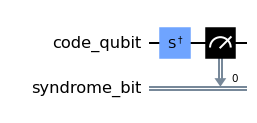

In [5]:
qc.draw(output='mpl', filename = 'Basic_single_qubit_error_circuit.jpg', fold=60)

 An example transpiled circuit is shown below.

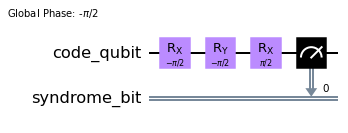

In [6]:
qt.draw(output='mpl', filename = 'Basic_single_qubit_error_circuit_transpiled.jpg', fold=60)